In [17]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def query_tags(tadf, mesh_list, time_range):
    min_date = int(time_range[0])
    max_date = int(time_range[1])
    match_df = tadf.loc[(np.isin(tadf.mesh_id, mesh_list))&(tadf.year<=max_date)&(tadf.year>=min_date),:] # find matches for the mesh list
    return match_df

def get_counts_per_year(matchdf):
    # counts per year
    ts = matchdf[['geo_id', 'year', 'aux']].groupby(['geo_id', 'year']).mean().reset_index()[['geo_id', 'year']]
    cpy = ts.groupby('year').size().reset_index(name='c')
    # make sure that all years are in df
    all_years = pd.DataFrame(pd.Series(np.arange(cpy.year.astype(int).min(), cpy.year.astype(int).max(),1)), columns = ['year'])
    all_years['aux'] = 1
    cpy_merge = pd.merge(all_years, cpy, on = 'year', how='outer')
    cpy_merge = cpy_merge.drop('aux', axis = 1)
    cpy_merge.loc[cpy_merge.c.isnull(), 'c'] = 0
    return cpy_merge

def get_samples_per_year(matchdf):
    ts = matchdf.groupby(['geo_id', 'year']).nsamples.mean().reset_index()
    spy = ts.groupby('year').nsamples.sum().reset_index()
    all_years = pd.DataFrame(pd.Series(np.arange(cpy.year.astype(int).min(), cpy.year.astype(int).max(),1)), columns = ['year'])
    all_years['aux'] = 1
    spy = pd.merge(all_years, spy, on = 'year', how='outer')
    spy = spy.drop('aux', axis = 1)
    spy.loc[spy.nsamples.isnull(), 'nsamples'] = 0
    return spy

# load tree
path = '../data/final'
tree_file = 'mesh.pkl'
trdf = pd.read_pickle(os.path.join(path, tree_file))

# load tags
tag_file ='geo.pkl'
tadf = pd.read_pickle(os.path.join(path, tag_file))
tadf['year'] = (tadf.date.str[:4]).astype(int) # year
tadf = pd.merge(tadf,trdf[['mesh_id', 'mesh_treenumbers']], on='mesh_id', how='left')

rank_file ='All_Time_Top.pkl'
rankdf = pd.read_pickle(os.path.join(path, rank_file))

In [143]:
# compute counts
attribute = 'Diseases' # ['Diseases', 'Drugs']
metric = 'Degree' # ['Degree', 'EigenCentrality', 'PageRank']
min_date = '1990'
max_date = '2017'
ntopdisease = 7
tadf = tadf[tadf.category=='C']

attr = list(rankdf.columns.levels[0])
metrics = list(rankdf.columns.levels[1])
mesh_ids = list(rankdf[attribute][metric][:ntopdisease])
mesh_headings = list(trdf.loc[np.isin(trdf.mesh_id, mesh_ids),'mesh_heading'])

countdf = pd.DataFrame()
sampledf = pd.DataFrame()
for iid, ihead in zip(mesh_ids, mesh_headings):
    time_range = [min_date, max_date]
    matchdf = query_tags(tadf, [iid], time_range)
    matchdf['year'] = matchdf.date.astype(str).str[:4].astype(int)
    matchdf['aux'] = 1
    cpy = get_counts_per_year(matchdf); cpy['mesh_id'] = iid; cpy['mesh_heading'] = ihead; 
    spy = get_samples_per_year(matchdf); spy['mesh_id'] = iid; spy['mesh_heading'] = ihead;
    countdf = countdf.append(cpy)
    sampledf = sampledf.append(spy)

/Users/clairechambers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/clairechambers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


time series


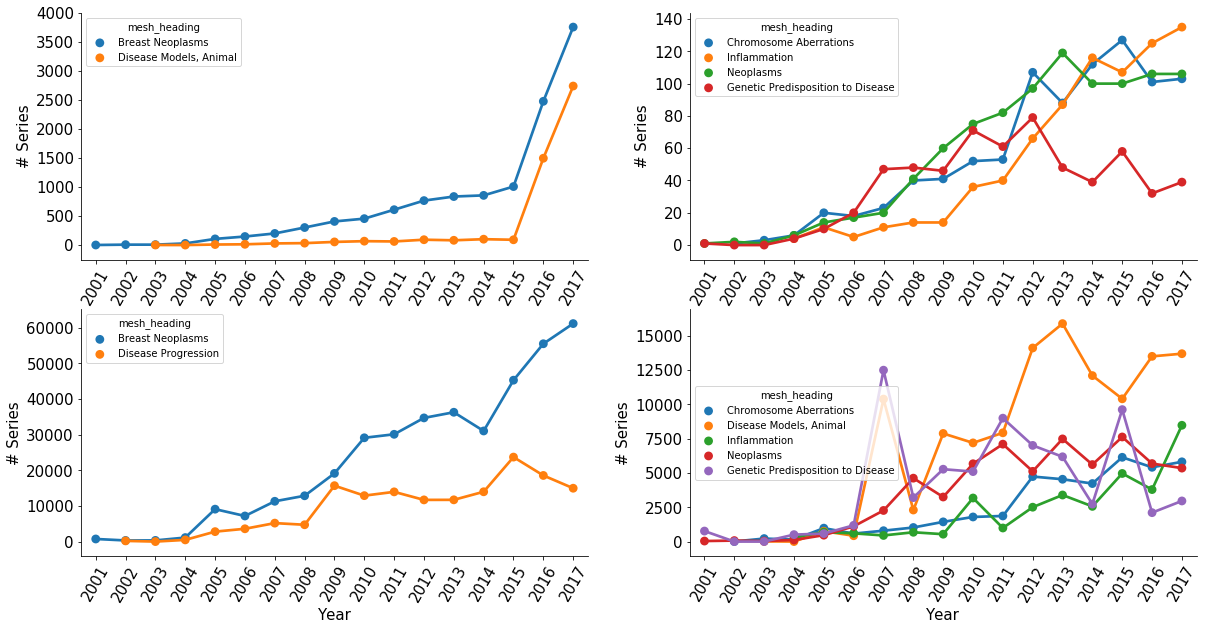

In [145]:
# some diseases have far series more than the rest

thrc = 400
thrs = 20000

maxcounts = countdf.groupby('mesh_heading').max().reset_index()
maxoverthr = maxcounts.loc[maxcounts.c>thrc,'mesh_heading'].tolist()
maxunderthr = maxcounts.loc[maxcounts.c<thrc,'mesh_heading'].tolist()
counts_more_common = countdf[np.isin(countdf.mesh_heading,maxoverthr)]
counts_more_rare = countdf[np.isin(countdf.mesh_heading,maxunderthr)]

maxcounts = sampledf.groupby('mesh_heading').max().reset_index()
maxoverthr = maxcounts.loc[maxcounts.nsamples>thrs,'mesh_heading'].tolist()
maxunderthr = maxcounts.loc[maxcounts.nsamples<thrs,'mesh_heading'].tolist()
samples_more_common = sampledf[np.isin(sampledf.mesh_heading,maxoverthr)]
samples_more_rare = sampledf[np.isin(sampledf.mesh_heading,maxunderthr)]


label_font = 15
fig,axs =plt.subplots(2,2, figsize=(20,10))

print('time series')

ax = axs[0,0]
sns.pointplot(data=counts_more_common, x='year', y = 'c', hue='mesh_heading', ax = ax)
# ax.plot(cpy.year, cpy.c, lw = 2) 
ax.set_xticks(range(len(countdf.year.unique())))
ax.set_xticklabels(cpy.year, rotation=60,fontsize=label_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel('# Series',fontsize = label_font)

ax = axs[0,1]
sns.pointplot(data=counts_more_rare, x='year', y = 'c', hue='mesh_heading', ax = ax)
ax.set_xticks(range(len(countdf.year.unique())))
ax.set_xticklabels(cpy.year, rotation=60,fontsize=label_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel('# Series',fontsize = label_font)

ax = axs[1,0]

sns.pointplot(data=samples_more_common, x='year', y = 'nsamples', hue='mesh_heading', ax = ax)
# ax.plot(cpy.year, cpy.c, lw = 2) 
ax.set_xticks(range(len(countdf.year.unique())))
ax.set_xticklabels(cpy.year, rotation=60,fontsize=label_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel('# Series',fontsize = label_font)

ax = axs[1,1]
sns.pointplot(data=samples_more_rare, x='year', y = 'nsamples', hue='mesh_heading', ax = ax)
ax.set_xticks(range(len(countdf.year.unique())))
ax.set_xticklabels(cpy.year, rotation=60,fontsize=label_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel('# Series',fontsize = label_font)
sns.despine()
# plt.show()

In [175]:
# now get n occurrences

tadf['for_counts'] = 1
n_mentions = tadf.groupby(['mesh_id', 'geo_id']).for_counts.mean().reset_index()
n_mentions['n'] = 1
n_mentions_by_disease = n_mentions.groupby('mesh_id').n.sum().reset_index().sort_values('n').reset_index(drop=True)

def get_unique_occurrences(tadf,mesh_and_tree, imesh):
    tree_list = mesh_and_tree[np.isin(mesh_and_tree.mesh_id,imesh)].mesh_treenumbers.to_list()
    geo_list = []
    for itree in tree_list: 
        geo_list_aux = tadf.loc[tadf.mesh_treenumbers.str[:len(itree)]==itree,'geo_id'].to_list()
        geo_list.append(geo_list_aux)
    n_geo = len(np.unique(np.array(geo_list)))
    return n_geo

mesh_and_tree = tadf.groupby(['mesh_id', 'mesh_treenumbers']).for_counts.mean().reset_index()
unique_mesh = tadf.mesh_id.unique()

n_geo_list = []
for imesh in unique_mesh:
    n_geo = get_unique_occurrences(tadf,mesh_and_tree, imesh)
    n_geo_list.append(n_geo)

n_mentions_by_disease_descendents = pd.DataFrame.from_dict({'mesh_id':pd.Series(unique_mesh) , 'n': pd.Series(n_geo_list)})
n_mentions_by_disease_descendents

# from here get top 10 mesh ids by noccurrence
# check zero entry
# look at highest level of hierarchy -- for each type how common are the subtypes



,mesh_id,n
0,D014604,24
1,D012878,300
2,D008545,815
3,D018450,1013
4,D009361,766
5,D002292,339
6,D007680,439
7,D007674,888
8,D002277,3992
9,D012164,269
